# Studying the Two Running Games in Super Bowl LVII

Every February millions of people, both inside and outside of North America, tune into the National Football League's Super Bowl, which crowns the world champion in American football.
In football there are two ways to advance the football while on offense; running and passing.
During this training, you will learn how to use data to see which players to watch out for during Super Bowl LVII in the running game, the more unheralded aspect of a football game.
We will show you how to obtain NFL play-by-play data in Python and then use exploratory data analysis and linear models to show which players will be the ones to watch during Super Bowl LVII.

### Obtaining data and loading packages

While we use Python in this tutorial, the `nflfastR` play-by-play datatset was developed initially in R, and the package's [help page](https://www.nflfastr.com/articles/field_descriptions.html) that gives the best description of the metadata.
You can obtain data for any year using `import_pbp_data()` from the `nfl_data_py` package and we included this code commented out for your future reference.
However, we pre-stage the data for this live training as a csv file to optimize your learning experience.

First, load the required python packages.
Use `pandas` (alias `pd`) and `numpy` (alias `np`) for data.
Use `seaborn` (alias `sns`) and `matplotlib.pyplot` (alias `plt`) for plotting.
Use `statsmodels.formula.api` alias `smf` for linear models.

In [1]:
# impoport required packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

**Note:** If you wanted to import the data for other seasons, you could use the code Eric and Richard used to obtain the original data:

```python
# code we used to obtain data
import nfl_data_py as nfl
pbp = nfl.import_pbp_data([2022])
# we only selected the columns we needed for today
pbp[['play_type', 'posteam', 'rushing_yards', 'rusher_id',
     'rusher_player_id', 'rusher_player_name', 'ydstogo', 'down',
     'yardline_100', 'run_location', 'score_differential',
     'game_seconds_remaining']].to_csv("pbp_2022.csv", index=False)
```

Now, you can load the _play-by-play (_pbp_) data you'll use today using `pd.read_csv()` with `pbp_2022.csv):

In [2]:
# load play-by-play data 
pbp = pd.read_csv("pbp_2022.csv")

Next, peak at the top of `pbp` using the `.head()`

In [3]:
# peak at head of pbp data
pbp.head()

,play_type,posteam,rushing_yards,rusher_id,rusher_player_id,rusher_player_name,ydstogo,down,yardline_100,run_location,score_differential,game_seconds_remaining
0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,3600.0
1,kickoff,NYJ,NaN,NaN,NaN,NaN,0.0,NaN,35.0,NaN,0.0,3600.0
2,run,NYJ,19.0,00-0036924,00-0036924,Mi.Carter,10.0,1.0,78.0,left,0.0,3596.0
3,pass,NYJ,NaN,NaN,NaN,NaN,10.0,1.0,59.0,NaN,0.0,3569.0
4,run,NYJ,5.0,00-0036924,00-0036924,Mi.Carter,10.0,2.0,59.0,left,0.0,3565.0


## Filtering Data to Rushing Plays

First, the `pbp` data needs to be filtered cleaned.
Use `query()` to preform the following:

* Save the new data frame as `pbp_run` because this is only the run play-by-play (_pbp_) data
* Filter (or, in `pandas` lingo, `query()`) to rushing plays with `play_type == "run"`
* Remove missing values for rushing_yards using `rushing_yards.notnull()`
* Remove missing values for rusher_id `rusher_id.notnull()`
* Rest the data frame's index, and 
* Look at the header of the data frame

Remember, use `&` to merge multiple filter criteria.
After filtering, look at the `head()` of the data:

In [4]:
## filter bpb
pbp_run = pbp.query('play_type == "run" & rushing_yards.notnull() & rusher_id.notnull()').reset_index()
pbp_run.head()

,index,play_type,posteam,rushing_yards,rusher_id,rusher_player_id,rusher_player_name,ydstogo,down,yardline_100,run_location,score_differential,game_seconds_remaining
0,2,run,NYJ,19.0,00-0036924,00-0036924,Mi.Carter,10.0,1.0,78.0,left,0.0,3596.0
1,4,run,NYJ,5.0,00-0036924,00-0036924,Mi.Carter,10.0,2.0,59.0,left,0.0,3565.0
2,9,run,BAL,4.0,00-0034796,00-0034796,L.Jackson,2.0,3.0,64.0,right,0.0,3461.0
3,10,run,BAL,0.0,00-0033118,00-0033118,K.Drake,10.0,1.0,60.0,right,0.0,3421.0
4,12,run,BAL,1.0,00-0033118,00-0033118,K.Drake,2.0,3.0,52.0,right,0.0,3340.0


## Who Are the Best Rushers in Sunday's Game?

Next, you will examine which players are the best at rushing the football for the players will be in the game on Sunday.
First, select the data for the two teams in the Super Bowl, the Philadelphia Eagles and the Kansas City Chiefs using the `isin` function from `pandas` with the Team of Possession (which team has the ball; `posteam`) column. To this,

1. Create a list of Super Bowl teams, `sb_teams`
2. Use the `.loc` command with `pbp_run` and the `.isin()` function on `posteam` column (**Hint:**, this looks like `pbp_run['posteam'].isin(sb_teams)`).
3. `reset_index()` on the new data frame
4. Save the outputs as `pbp_run_sb`

In [5]:
# create a list of teams in the Super Bowl
sb_teams = ["PHI", "KC"]

# Filter out only the Super Bowl teams using `isin()`
pbp_run_sb =  \
    pbp_run.loc[pbp_run['posteam'].isin(sb_teams)].reset_index()

Next, check the data to make sure it is correct and you only have these two teams by using the `posteam` column and looking for the `unique()` values in the column:

In [6]:
# Look at the unique `posteam` values in `pbp_run_sb()`
pbp_run_sb.posteam.unique()

array(['KC', 'PHI'], dtype=object)

Now, you can aggregate over the whole season for each player's rushing yards (sum of rushing_yards) and yards-per-carry (mean of rushing yards).
For this, "group by" the `posteam` so we know which team the player belongs to, and both `rusher_player_id` and `rusher_player_name` because some players have the same name.
Last, sort by the player's rushing yards with `ascending=[False]` to help us see who had the most yards:

In [7]:
# groupby ["posteam", "rusher_player_id", "rusher"]
# then aggregate `{"rushing_yards": ["sum", "mean", "count"]}`
pbp_run_sb_yards = \
    pbp_run_sb.groupby(
    ["posteam", "rusher_player_id", "rusher_player_name"]).agg(
    {"rushing_yards": ["sum", "mean", "count"]})

# Look at the results by sorting by `('rushing_yards', 'sum')`
pbp_run_sb_yards.sort_values(('rushing_yards', 'sum'),
                             ascending=[False])

rushing_yards                 
                                                      sum       mean count
posteam rusher_player_id rusher_player_name                               
PHI     00-0035243       M.Sanders                 1401.0   4.881533   287
KC      00-0037197       I.Pacheco                  951.0   4.953125   192
PHI     00-0036389       J.Hurts                    521.0   4.378151   119
        00-0036919       K.Gainwell                 400.0   5.063291    79
KC      00-0031376       J.McKinnon                 317.0   3.643678    87
        00-0036360       C.Edwards-Helaire          302.0   4.253521    71
PHI     00-0034414       B.Scott                    270.0   4.090909    66
KC      00-0036913       K.Toney                     73.0  12.166667     6
        00-0034816       R.Jones                     70.0   3.888889    18
        00-0035140       M.Hardman                   38.0   6.333333     6
        00-0038090       S.Moore                     27.0   6.750000     4
        00-0033873       P.Mahomes                   20.0   3.333333     6
PHI     00-0036984       T.Sermon                    19.0   9.500000     2
KC      00-0031595       M.Burton                     7.0   1.400000     5
        00-0030506       T.Kelce                      5.0   2.500000     2
        00-0036637       N.Gray                       1.0   0.500000     2
PHI     00-0035289       G.Minshew                    1.0   0.333333     3
        00-0036271       Q.Watkins                    1.0   0.333333     3
        00-0033251       Z.Pascal                     0.0   0.000000     1
KC      00-0034272       M.Valdes-Scantling          -3.0  -3.000000     1

Notice also that the leading rusher for the Chiefs is Isiah Pacheco, who is a seventh-round pick in the most-recent NFL draft out of Rutgers

The Eagles' two leading rushers are their starting running back Miles Sanders and their quarterback Jalen Hurts.
This is just a subset of Hurts' overall rushing performance, since he often "scrambles" on passing plays, which count as rushing yards even though they are the result of passing plays.

Is this the end of the story? Give the time on the clock remaining for this live training, you can hopefully guess the answer.

## Rushing Yards Over Expected: Building linear model

The winning solution to the 2020 [Big Data Bowl](https://operations.nfl.com/gameday/analytics/big-data-bowl/), an analytics competition held by the NFL each year, resulted in the construction of an expectation metric for rushing yardage that depended on a number of factors.
From there, one can look at the residual between actual outcome an expected outcome - called rushing yards over expected (RYOE) for more insight into how well the rusher did relative to expectations.

Here, we fit a simple linear model based only on the number of yards to go for a first down.
Generally speaking, defenses play closer to the line of scrimmage when there are fewer yards to go, making rushing yardage harder to gain the closer `ydstogo` gets to 0.

* Use the `smf.ols()` function with `rushing_yards` predicted by an intercept and `ydstogo`.
* Use the input data `* Use the input data`
* Save the output as `yard_to_go`

In [8]:
# use the smf.ols() with a formula and data
yard_to_go = smf.ols(formula = "rushing_yards ~ 1 + ydstogo",
                    data = pbp_run)

Next, extract the `fit()` and then print the `summary()`:

In [9]:
yard_to_go_fit = yard_to_go.fit()
print(yard_to_go_fit.summary())

                            OLS Regression Results                            
Dep. Variable:          rushing_yards   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     96.54
Date:                Fri, 03 Feb 2023   Prob (F-statistic):           1.03e-22
Time:                        16:26:36   Log-Likelihood:                -45653.
No. Observations:               13995   AIC:                         9.131e+04
Df Residuals:                   13993   BIC:                         9.132e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.3463      0.122     27.340      0.0

Notice that the coefficient for `ydstogo` is positive - a rusher is expected to gain more yards the further his team is from the first down market.
Let's explore the outcome of this model.

Lastly, create a new column, _run yards over expected_ or `ryoe` in `pbp_run` from `yard_to_go_fit.resid`:

In [10]:
# create ryoe column in pbp_run
pbp_run["ryoe"] = yard_to_go_fit.resid

### RYOE for Super Bowl Rushers

First, you will need to filter out only the two teams in the Super Bowl.
You will results the object `sb_teams` from before, so you may need to go up and load this if you're jumping into the notebook now.
To do the filter, use the same `isin()` function as before (the new data frame is called pbp_ryoe_sb to be different from the previously data frame created above):

* Use `loc[]` with pbp_run
* use `isin()` with `sb_teams`
* Be sure to `reset_index()`
* Save the new data frame as `pbp_ryoe_sb`

In [11]:
# filter out sb teams to create pbp_ryoe_sb
pbp_ryoe_sb = pbp_run.loc[pbp_run['posteam'].isin(sb_teams)].reset_index()

Next, use the same grouping used before to calculate each player's rushing yards (sum of rushing_yards), yards-per-carry (mean of rushing yards), total rushing ards over expected (TYOE; sum of RYOE), and average RYOE (mean of RYOE).
Sort by the TYOE:

In [12]:
# create pbp_ryoe_sb_yards
# group by ["posteam", "rusher_player_id", "rusher"]
# then aggregate with "rushing_yards": ["sum", "mean"]
# as well as "ryoe": ["sum", "mean", "count"]
pbp_ryoe_sb_yards = \
    pbp_ryoe_sb.groupby(
    ["posteam", "rusher_player_id", "rusher_player_name"]).agg(
    {"rushing_yards": ["sum", "mean"],
     "ryoe": ["sum", "mean", "count"]})
# look at the results using sort_values on ('ryoe',   'sum')
# be sure to set ascending=[False]
pbp_ryoe_sb_yards.sort_values(
    ('ryoe',   'sum'),
    ascending=[False])

rushing_yards             \
                                                      sum       mean   
posteam rusher_player_id rusher_player_name                            
PHI     00-0035243       M.Sanders                 1401.0   4.881533   
KC      00-0037197       I.Pacheco                  951.0   4.953125   
PHI     00-0036919       K.Gainwell                 400.0   5.063291   
KC      00-0036913       K.Toney                     73.0  12.166667   
PHI     00-0036389       J.Hurts                    521.0   4.378151   
KC      00-0035140       M.Hardman                   38.0   6.333333   
PHI     00-0036984       T.Sermon                    19.0   9.500000   
KC      00-0038090       S.Moore                     27.0   6.750000   
        00-0030506       T.Kelce                      5.0   2.500000   
PHI     00-0033251       Z.Pascal                     0.0   0.000000   
KC      00-0036637       N.Gray                       1.0   0.500000   
        00-0033873       P.Mahomes                   20.0   3.333333   
        00-0034272       M.Valdes-Scantling          -3.0  -3.000000   
        00-0036360       C.Edwards-Helaire          302.0   4.253521   
        00-0034816       R.Jones                     70.0   3.888889   
        00-0031595       M.Burton                     7.0   1.400000   
PHI     00-0035289       G.Minshew                    1.0   0.333333   
        00-0036271       Q.Watkins                    1.0   0.333333   
        00-0034414       B.Scott                    270.0   4.090909   
KC      00-0031376       J.McKinnon                 317.0   3.643678   

                                                   ryoe                  
                                                    sum      mean count  
posteam rusher_player_id rusher_player_name                              
PHI     00-0035243       M.Sanders           127.009855  0.442543   287  
KC      00-0037197       I.Pacheco            95.526355  0.497533   192  
PHI     00-0036919       K.Gainwell           60.317066  0.763507    79  
KC      00-0036913       K.Toney              47.531956  7.921993     6  
PHI     00-0036389       J.Hurts              29.635937  0.249041   119  
KC      00-0035140       M.Hardman            14.466930  2.411155     6  
PHI     00-0036984       T.Sermon             10.372440  5.186220     2  
KC      00-0038090       S.Moore              10.021304  2.505326     4  
        00-0030506       T.Kelce              -3.074711 -1.537355     2  
PHI     00-0033251       Z.Pascal             -3.484506 -3.484506     1  
KC      00-0036637       N.Gray               -5.969011 -2.984506     2  
        00-0033873       P.Mahomes            -7.126593 -1.187766     6  
        00-0034272       M.Valdes-Scantling   -7.728417 -7.728417     1  
        00-0036360       C.Edwards-Helaire    -9.115828 -0.128392    71  
        00-0034816       R.Jones              -9.583017 -0.532390    18  
        00-0031595       M.Burton            -10.422528 -2.084506     5  
PHI     00-0035289       G.Minshew           -10.697429 -3.565810     3  
        00-0036271       Q.Watkins           -11.941341 -3.980447     3  
        00-0034414       B.Scott             -21.758326 -0.329672    66  
KC      00-0031376       J.McKinnon          -72.258332 -0.830556    87

Notice that while Pacheo was close to Sanders in terms of yards per carry, and trailed him in total rushing yards, he is pretty close to him in total RYOE and is much better than he is in average RYOE per carry. 
Let's look at the play-level distributions of these players for guys with more than 20 carries during the course of the season.
We include the cleaning code, because, while we spend most of our time cleaning data, we do not want this training to be a `pandas` session on cleaning data.

We used the value 20 because we only want players who had a large number of players:
First, clean up the column names to be easier to work with:

In [13]:
# first, flatten the columns of pbp_ryoe_sb_yards
pbp_ryoe_sb_yards.columns = list(map(''.join, pbp_ryoe_sb_yards.columns.values))

# Then rename columns
pbp_ryoe_sb_yards.rename(
    {'rushing_yardssum': 'total rushing yards',
     'rushing_yardsmean': 'yards per play',
     'ryoesum': 'TYOE',
     'ryoemean': 'average RYOE',
     'ryoecount': 'carries'
      }, axis=1, inplace=True)

# Filter for carries >= 20 and sort values by TYOE, ascending=False
top_players_summary = pbp_ryoe_sb_yards.query('carries >= 20').sort_values("TYOE", ascending=False)
top_players_summary

total rushing yards  \
posteam rusher_player_id rusher_player_name                        
PHI     00-0035243       M.Sanders                        1401.0   
KC      00-0037197       I.Pacheco                         951.0   
PHI     00-0036919       K.Gainwell                        400.0   
        00-0036389       J.Hurts                           521.0   
KC      00-0036360       C.Edwards-Helaire                 302.0   
PHI     00-0034414       B.Scott                           270.0   
KC      00-0031376       J.McKinnon                        317.0   

                                             yards per play        TYOE  \
posteam rusher_player_id rusher_player_name                               
PHI     00-0035243       M.Sanders                 4.881533  127.009855   
KC      00-0037197       I.Pacheco                 4.953125   95.526355   
PHI     00-0036919       K.Gainwell                5.063291   60.317066   
        00-0036389       J.Hurts                   4.378151   29.635937   
KC      00-0036360       C.Edwards-Helaire         4.253521   -9.115828   
PHI     00-0034414       B.Scott                   4.090909  -21.758326   
KC      00-0031376       J.McKinnon                3.643678  -72.258332   

                                             average RYOE  carries  
posteam rusher_player_id rusher_player_name                         
PHI     00-0035243       M.Sanders               0.442543      287  
KC      00-0037197       I.Pacheco               0.497533      192  
PHI     00-0036919       K.Gainwell              0.763507       79  
        00-0036389       J.Hurts                 0.249041      119  
KC      00-0036360       C.Edwards-Helaire      -0.128392       71  
PHI     00-0034414       B.Scott                -0.329672       66  
KC      00-0031376       J.McKinnon             -0.830556       87

Now, let's look at the data.
First, create a histogram of all RYOE data.
Notice the "tent pole" in the middle of the distribution, as well as the right skew:

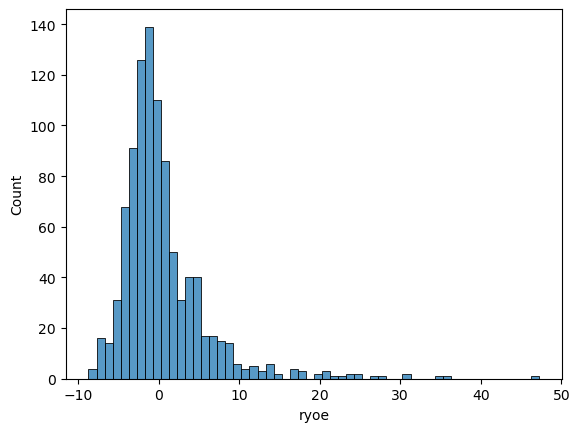

In [14]:
# create a histoplot() from sns. Use pbp_ryoe_sb data 
# and set binwidth=1
sns.histplot(x='ryoe', data=pbp_ryoe_sb, binwidth=1);

Next, extract out data for the top rushers and create a new data frame, `top_ryoe`:

In [15]:
# create top_ryoe
# use pbp_run['rusher_player_name'].isin(top_players_summary.reset_index().rusher)
# as the filter criteria
pbp_run['rusher_player_name']

0         Mi.Carter
1         Mi.Carter
2         L.Jackson
3           K.Drake
4           K.Drake
            ...    
13990      D.Samuel
13991       B.Scott
13992       B.Scott
13993       B.Scott
13994    K.Gainwell
Name: rusher_player_name, Length: 13995, dtype: object

In [16]:
## Next, create top_ryoe from pbp_ryoe_sb
## use pbp_run['rusher_player_name'].isin(top_players_summary.reset_index().rusher_player_name)
## for the search criteria
top_ryoe = \
    pbp_ryoe_sb[pbp_run['rusher_player_name'].isin(top_players_summary.reset_index().rusher_player_name)]

C:\Users\ruthe\AppData\Local\Temp\ipykernel_3384\2996745349.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pbp_ryoe_sb[pbp_run['rusher_player_name'].isin(top_players_summary.reset_index().rusher_player_name)]


Next, recreate this plot with each player as their own sub-plot.
First, create a subset of the data so we only look at players with 20 or more plays.
Also, change the `hue` so we can tell the two teams apart:

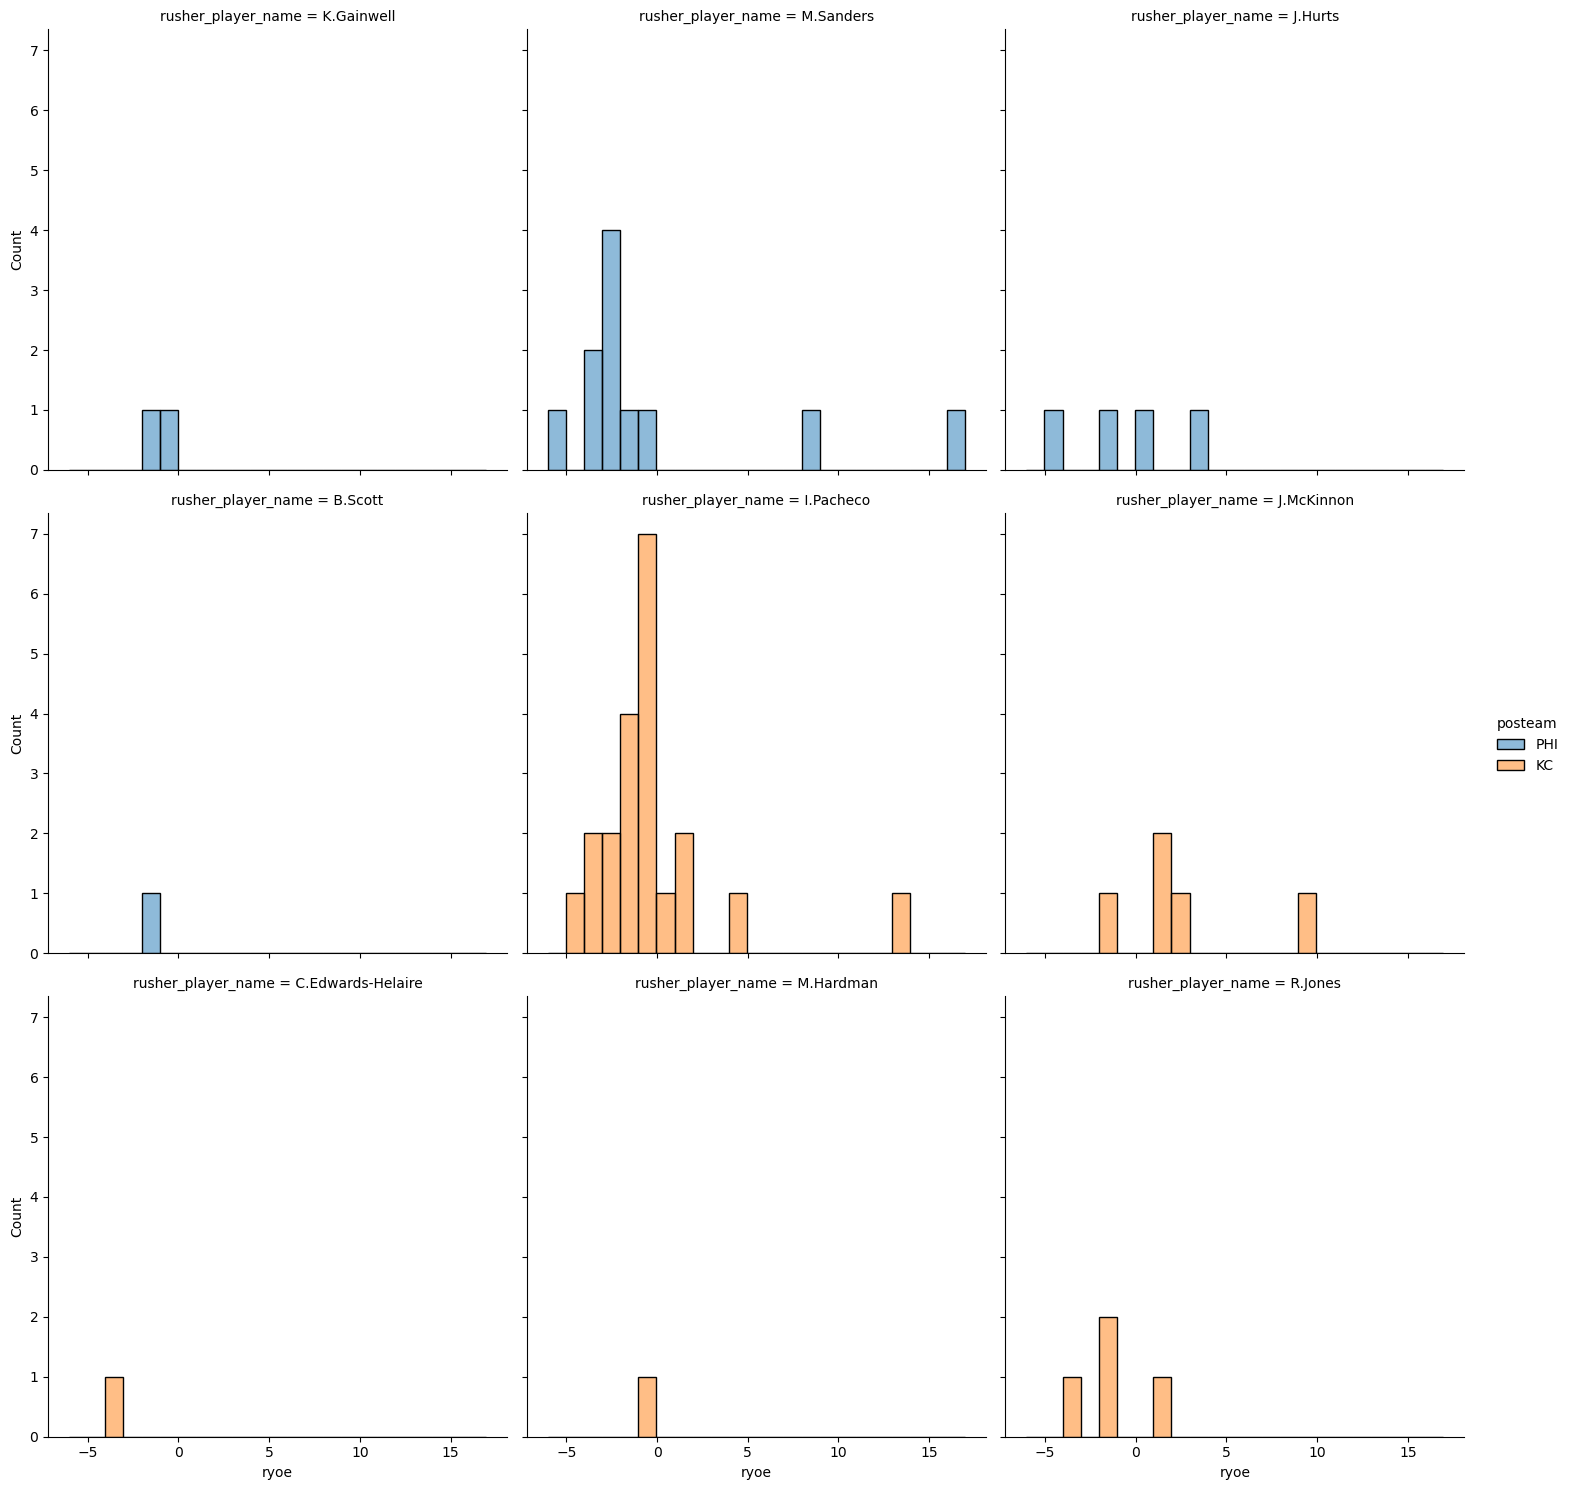

In [17]:
# use displot from sns
# data from top_ryoe, binwidth=1, x=ryoe
# col=rusher_player_name and col_wrap=3d
sns.displot(data = top_ryoe, binwidth=1, x ='ryoe',
            col='rusher_player_name', hue='posteam',
            col_wrap=3);

Notice that, while Jerick McKinnon has scored 83 touchdowns for the Chiefs this year, he's actually struggled running the back relative to expectations pre-snap.
Former first-round pick Clyde Edwards-Helaire has ails well, with a negative RYOE, which opened the door for seventh-round pick Pacheco to shine.

Athough providing a great amount of detail, these histograms actually provide too much dteail and can be hard to examine.
Let's look at this same data with a boxplot.  

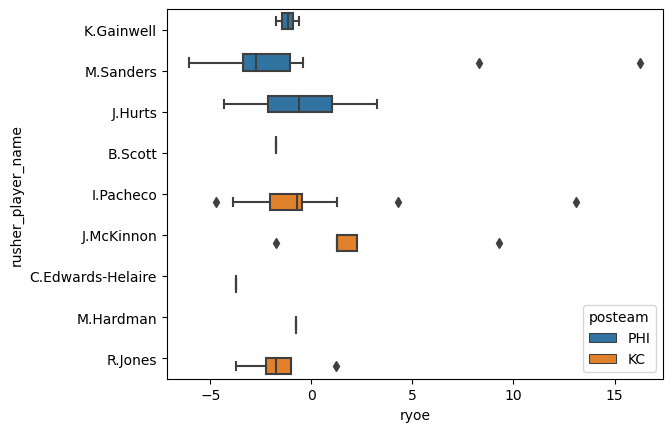

In [18]:
# Use sns bxoplot
# top_ryoe data
# x is ryoe, y is rusher_player_name, hue is posteam
sns.boxplot(data=top_ryoe, 
            x="ryoe",
            y="rusher_player_name",
            hue = 'posteam');

### Conclusions for simple model

What have we learned from this simple modeling exercise?

* Rushing yards over expected is right skewed! 
* Sanders and Pacheco have shined, while Scott, Edwards-Helaire and McKinnon have struggled
* Much of data science, even with "package" data still requires data wrangling!

While anything can happen in Sunday's game, watch out for Sanders and Pacheco.

Lastly, check out our forthcoming book, [Football Analytics with Python & R](https://learning.oreilly.com/library/view/football-analytics-with/9781492099611/]) or our DataCamp courses to learn about [Linear Algebra in R](https://app.datacamp.com/learn/courses/linear-algebra-for-data-science-in-r), [Hierarchical and Mixed-effect Models in R](https://app.datacamp.com/learn/courses/hierarchical-and-mixed-effects-models-in-r), or [Generalized Linear Models in R](https://app.datacamp.com/learn/courses/generalized-linear-models-in-r).
And feel free to follow Eric on [Twitter](https://twitter.com/ericeager__) or [LinkedIn](https://www.linkedin.com/in/eric-eager-31a2a220) and Richard on [LinkedIn](https://www.linkedin.com/in/raerickson).

## Q and A

Questions?

### Multiple Regression

But, what about a more complex model? Can you do better at predicting?
As a bonus, we include the code for a more complicated model.

We have more powerful tools in our toolbox compared to a simple linear regression.
A next logical step would be to use multiple predictor variables and use a multiple regression.
There are other things that go into expected rushing success.
For example, which down it is?, how many yards the team has to go to reach the end zone?, what is the run direction?, what is the score differential? how much time is remaining?

Depending upon the purpose of the extra variables, you might say you are _correcting_ for other predictors (a term commonly used in the medical field, for example, when Richie Cotton worked at a Medical College he would have used the term).
Or, we may want to simply include multiple predictors.
However, this added realism comes at a trade-off of complexity.

If you are joining us late, please make sure you load the data from the previous part of the tutorial.
First, reformat `down` to be a string.
This will cause Python's regression to treat `down` as a category, rather than an a continuous predictor:

In [19]:
# Convert down from pbp_run to be a string using astype(str)
pbp_run["down"] = pbp_run["down"].astype(str)

Next, let's build a model and examine the fit's summary.
Because the formula is long, define it first to make your code easier to read:

In [20]:
# include "rushing_yards ~ 1 + ydstogo + down + yardline_100 + run_location + score_differential + game_seconds_remaining"
m1_formula = "rushing_yards ~ 1 + ydstogo + down + yardline_100 + run_location + score_differential + game_seconds_remaining"

In [21]:
# next build the model, extract the fit, and print the summary
model_1 = \
    smf.ols(formula = m1_formula, data = pbp_run)
model_1_fit = model_1.fit()
print(model_1_fit.summary())

                            OLS Regression Results                            
Dep. Variable:          rushing_yards   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     26.68
Date:                Fri, 03 Feb 2023   Prob (F-statistic):           3.20e-46
Time:                        16:26:49   Log-Likelihood:                -45211.
No. Observations:               13872   AIC:                         9.044e+04
Df Residuals:                   13862   BIC:                         9.052e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  2

Now, extract out RYOE, similar to and calculate the same summaries as before:

In [22]:
# extract out the residual from model 1
pbp_run["ryoe_m1"] = model_1_fit.resid
# use .loc to extract out the sb_teams
pbp_ryoe_sb = pbp_run.loc[pbp_run['posteam'].isin(sb_teams)].reset_index()
# group by ["posteam", "rusher_player_id", "rusher_player_name"]
# aggregate with a dictionary
#    {"rushing_yards": ["sum", "mean"],
#     "ryoe": ["sum", "mean"],
#     "ryoe_m1": ["sum", "mean", "count"]})
pbp_ryoe_sb_yards = \
    pbp_ryoe_sb.groupby(
    ["posteam", "rusher_player_id", "rusher_player_name"]).agg(
    {"rushing_yards": ["sum", "mean"],
     "ryoe": ["sum", "mean"],
     "ryoe_m1": ["sum", "mean", "count"]})
# lastly, sorty by ('ryoe_m1',   'sum')
pbp_ryoe_sb_yards.sort_values(
    ('ryoe_m1',   'sum'),
    ascending=[False])

rushing_yards             \
                                                      sum       mean   
posteam rusher_player_id rusher_player_name                            
PHI     00-0035243       M.Sanders                 1401.0   4.881533   
KC      00-0037197       I.Pacheco                  951.0   4.953125   
PHI     00-0036389       J.Hurts                    521.0   4.378151   
        00-0036919       K.Gainwell                 400.0   5.063291   
KC      00-0036913       K.Toney                     73.0  12.166667   
        00-0035140       M.Hardman                   38.0   6.333333   
PHI     00-0036984       T.Sermon                    19.0   9.500000   
KC      00-0038090       S.Moore                     27.0   6.750000   
        00-0033873       P.Mahomes                   20.0   3.333333   
        00-0030506       T.Kelce                      5.0   2.500000   
PHI     00-0033251       Z.Pascal                     0.0   0.000000   
        00-0035289       G.Minshew                    1.0   0.333333   
KC      00-0036637       N.Gray                       1.0   0.500000   
        00-0034816       R.Jones                     70.0   3.888889   
        00-0036360       C.Edwards-Helaire          302.0   4.253521   
        00-0034272       M.Valdes-Scantling          -3.0  -3.000000   
        00-0031595       M.Burton                     7.0   1.400000   
PHI     00-0034414       B.Scott                    270.0   4.090909   
        00-0036271       Q.Watkins                    1.0   0.333333   
KC      00-0031376       J.McKinnon                 317.0   3.643678   

                                                   ryoe               ryoe_m1  \
                                                    sum      mean         sum   
posteam rusher_player_id rusher_player_name                                     
PHI     00-0035243       M.Sanders           127.009855  0.442543  122.443124   
KC      00-0037197       I.Pacheco            95.526355  0.497533  100.233685   
PHI     00-0036389       J.Hurts              29.635937  0.249041   75.716739   
        00-0036919       K.Gainwell           60.317066  0.763507   66.194919   
KC      00-0036913       K.Toney              47.531956  7.921993   47.869484   
        00-0035140       M.Hardman            14.466930  2.411155   14.830122   
PHI     00-0036984       T.Sermon             10.372440  5.186220   10.689776   
KC      00-0038090       S.Moore              10.021304  2.505326   10.198662   
        00-0033873       P.Mahomes            -7.126593 -1.187766    6.592554   
        00-0030506       T.Kelce              -3.074711 -1.537355   -0.521638   
PHI     00-0033251       Z.Pascal             -3.484506 -3.484506   -2.280433   
        00-0035289       G.Minshew           -10.697429 -3.565810   -2.878324   
KC      00-0036637       N.Gray               -5.969011 -2.984506   -5.799529   
        00-0034816       R.Jones              -9.583017 -0.532390   -6.016950   
        00-0036360       C.Edwards-Helaire    -9.115828 -0.128392   -7.212082   
        00-0034272       M.Valdes-Scantling   -7.728417 -7.728417   -7.464172   
        00-0031595       M.Burton            -10.422528 -2.084506  -11.832910   
PHI     00-0034414       B.Scott             -21.758326 -0.329672  -12.137235   
        00-0036271       Q.Watkins           -11.941341 -3.980447  -12.167227   
KC      00-0031376       J.McKinnon          -72.258332 -0.830556  -51.317409   

                                                             
                                                 mean count  
posteam rusher_player_id rusher_player_name                  
PHI     00-0035243       M.Sanders           0.426631   287  
KC      00-0037197       I.Pacheco           0.524784   191  
PHI     00-0036389       J.Hurts             0.664182   114  
        00-0036919       K.Gainwell          0.837910    79  
KC      00-0036913       K.Toney             7.978247     6  
        00-0035140       M.

Next, reformat the data into a new summary table and only examine players with more than 20 carries:

In [23]:
# rename the columns in pbp_ryoe_sb_yards.
# using list(map(''.join, pbp_ryoe_sb_yards.columns.values))
pbp_ryoe_sb_yards.columns = list(map(''.join, pbp_ryoe_sb_yards.columns.values))

In [24]:
# also rename several columns
pbp_ryoe_sb_yards.rename(
    {'rushing_yardssum': 'total rushing yards',
     'rushing_yardsmean': 'yards per play',
     'ryoesum': 'TYOE',
     'ryoemean': 'average RYOE',
     'ryoe_m1sum': 'TYOE_m1',
     'ryoe_m1mean': 'average RYOE_m1',
     'ryoe_m1count': 'carries'
      }, axis=1, inplace=True)
# repeat the query on carries, and sort by TYOE_m1
top_players_summary = pbp_ryoe_sb_yards.query('carries >= 20')
top_players_summary.sort_values("TYOE_m1", ascending=False)

total rushing yards  \
posteam rusher_player_id rusher_player_name                        
PHI     00-0035243       M.Sanders                        1401.0   
KC      00-0037197       I.Pacheco                         951.0   
PHI     00-0036389       J.Hurts                           521.0   
        00-0036919       K.Gainwell                        400.0   
KC      00-0036360       C.Edwards-Helaire                 302.0   
PHI     00-0034414       B.Scott                           270.0   
KC      00-0031376       J.McKinnon                        317.0   

                                             yards per play        TYOE  \
posteam rusher_player_id rusher_player_name                               
PHI     00-0035243       M.Sanders                 4.881533  127.009855   
KC      00-0037197       I.Pacheco                 4.953125   95.526355   
PHI     00-0036389       J.Hurts                   4.378151   29.635937   
        00-0036919       K.Gainwell                5.063291   60.317066   
KC      00-0036360       C.Edwards-Helaire         4.253521   -9.115828   
PHI     00-0034414       B.Scott                   4.090909  -21.758326   
KC      00-0031376       J.McKinnon                3.643678  -72.258332   

                                             average RYOE     TYOE_m1  \
posteam rusher_player_id rusher_player_name                             
PHI     00-0035243       M.Sanders               0.442543  122.443124   
KC      00-0037197       I.Pacheco               0.497533  100.233685   
PHI     00-0036389       J.Hurts                 0.249041   75.716739   
        00-0036919       K.Gainwell              0.763507   66.194919   
KC      00-0036360       C.Edwards-Helaire      -0.128392   -7.212082   
PHI     00-0034414       B.Scott                -0.329672  -12.137235   
KC      00-0031376       J.McKinnon             -0.830556  -51.317409   

                                             average RYOE_m1  carries  
posteam rusher_player_id rusher_player_name                            
PHI     00-0035243       M.Sanders                  0.426631      287  
KC      00-0037197       I.Pacheco                  0.524784      191  
PHI     00-0036389       J.Hurts                    0.664182      114  
        00-0036919       K.Gainwell                 0.837910       79  
KC      00-0036360       C.Edwards-Helaire         -0.101579       71  
PHI     00-0034414       B.Scott                   -0.183898       66  
KC      00-0031376       J.McKinnon                -0.589855       87

The data requires one more manipulation, a melt, before the boxplot:

In [25]:
# flatten column names
top_ryoe = \
    pbp_ryoe_sb[pbp_run['rusher_player_name'].isin(top_players_summary.reset_index().rusher_player_name)]

C:\Users\ruthe\AppData\Local\Temp\ipykernel_3384\1865351197.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pbp_ryoe_sb[pbp_run['rusher_player_name'].isin(top_players_summary.reset_index().rusher_player_name)]


In [26]:
# melt 
top_ryoe_long = \
    pd.melt(top_ryoe[['posteam', 'rusher_player_id', 'rusher_player_name', 'ryoe', 'ryoe_m1']].reset_index(),
            id_vars=['posteam', 'rusher_player_id', 'rusher_player_name'],
            value_vars=['ryoe', 'ryoe_m1'],
            var_name = 'model',
            value_name = 'RYOE')

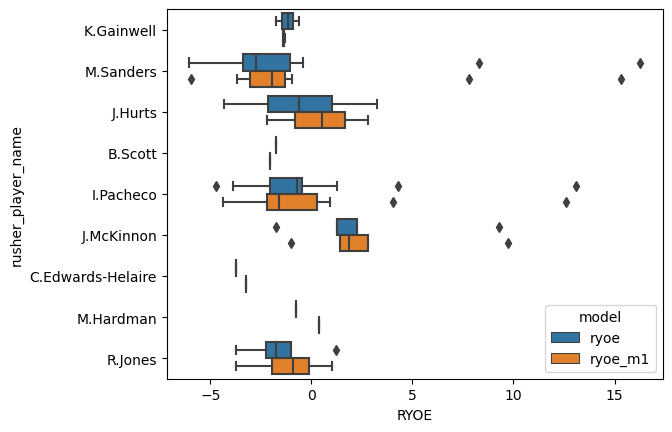

In [27]:
# sns boxplot
sns.boxplot(data=top_ryoe_long, 
            x='RYOE',
            y='rusher_player_name',
            hue = 'model');

Notice here that results are largely the same.
The best still the best, and the worst are still the worst.
However, Hurts and Gainwell change positions.

# Conclusion

In this training session we looked at real National Football League play-by-play data to gain insights into the running game for Super Bowl LVII.

You saw how a multiple regression produced similar, but slightly different results than the simple regression.
As a data scientist, which model would you use?
Conversely, if you had to explain the model as a football analysts on live TV or radio, which model would you use?